In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
print(f'Tensorflow version: {tf.__version__}')
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

Tensorflow version: 2.4.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
dataset = 1
if dataset == 1:
  root_folder = 'gdrive/MyDrive/Colab Notebooks/data/flower_images'
  df = pd.read_csv(os.path.join(root_folder, 'flower_labels.csv'))
  label = df['label'].tolist()
  unique_labels = list(set(label))
else:
  root_folder = 'gdrive/MyDrive/Colab Notebooks/data/flowers'
  unique_labels = [i for i in range(10)]
print(unique_labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [22]:
flowers = []
for file in os.listdir(root_folder):
  if file.endswith('.png'):
    flowers.append(file)

print('Loaded {} images'.format(len(flowers)))

Loaded 210 images


In [23]:
IMG_SIZE = (224, 224)

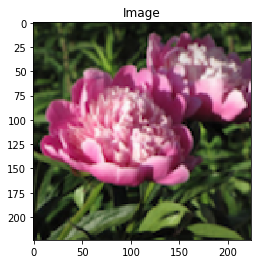

In [24]:
img = image.load_img(os.path.join(root_folder, flowers[0]), target_size=IMG_SIZE)
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
plt.figure()
plt.imshow(img)
plt.title('Image')
plt.show()

In [25]:
pretrained_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=True,
    input_shape=tuple([*IMG_SIZE, 3])
)

In [26]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
model = Model(inputs=pretrained_model.inputs, outputs=pretrained_model.layers[-2].output)

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [29]:
def extract_features(file, model):
  img = image.load_img(file, target_size=IMG_SIZE)
  img = np.array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img) # img / 255.
  features = model.predict(img)
  return features

In [30]:
data = dict()

for flower in flowers:
  data[flower] = extract_features(os.path.join(root_folder, flower), model)

In [31]:
num_features = data[flowers[0]].shape
num_features

(1, 4096)

In [32]:
features = np.array(list(data.values())).reshape(-1, num_features[1])
features.shape

(210, 4096)

## PCA

In [ ]:
pca = PCA(n_components=100, random_state=0)
pca.fit(features)
x = pca.transform(features)

In [ ]:
print('Components before PCA: {}'.format(num_features[1]))
print('Components after PCA: {}'.format(pca.n_components))

Components before PCA: 4096
Components after PCA: 100


## K Mean cluster

In [33]:
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [34]:
kmeans.labels_

array([2, 1, 0, 8, 5, 9, 9, 2, 0, 1, 4, 5, 2, 6, 8, 9, 5, 9, 5, 6, 9, 9,
       3, 5, 5, 0, 2, 5, 6, 1, 4, 2, 5, 9, 2, 4, 2, 5, 5, 6, 2, 4, 1, 2,
       4, 2, 5, 9, 2, 1, 8, 9, 7, 2, 1, 2, 2, 5, 4, 5, 9, 5, 9, 2, 8, 2,
       3, 5, 2, 5, 8, 5, 3, 1, 2, 0, 0, 5, 5, 2, 1, 3, 8, 9, 2, 0, 6, 2,
       2, 6, 2, 5, 9, 3, 5, 2, 5, 1, 1, 2, 1, 2, 6, 3, 6, 4, 4, 0, 2, 2,
       3, 0, 5, 8, 0, 3, 0, 1, 3, 4, 5, 6, 2, 5, 3, 5, 3, 3, 2, 5, 0, 8,
       3, 4, 4, 5, 3, 2, 1, 2, 5, 2, 3, 5, 2, 0, 2, 6, 7, 3, 3, 8, 0, 1,
       9, 8, 3, 9, 5, 8, 2, 9, 2, 6, 3, 2, 1, 2, 4, 6, 5, 5, 9, 2, 9, 5,
       5, 1, 5, 5, 8, 1, 2, 7, 9, 2, 6, 4, 1, 7, 1, 8, 6, 2, 3, 9, 1, 6,
       5, 2, 5, 4, 0, 5, 5, 6, 9, 9, 6, 6], dtype=int32)

In [35]:
groups = {}
for file, cluster in zip(flowers, kmeans.labels_):
  if cluster not in groups.keys():
    groups[cluster] = []
    groups[cluster].append(file)
  else:
    groups[cluster].append(file)

In [36]:
def show_images(folder, imgs, title):
  num_rows = 1
  num_cols = 10 if len(imgs) > 10 else len(imgs)
  fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
  for img, ax in zip(imgs, axs.flatten()):
    img_path = os.path.join(folder, img)
    ax.imshow(image.load_img(img_path, target_size=IMG_SIZE))
    ax.set_title(str(title))
    ax.axis('off')
  fig.tight_layout()
  plt.show()

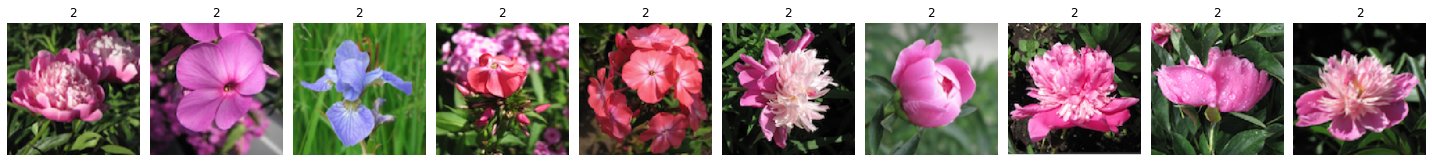

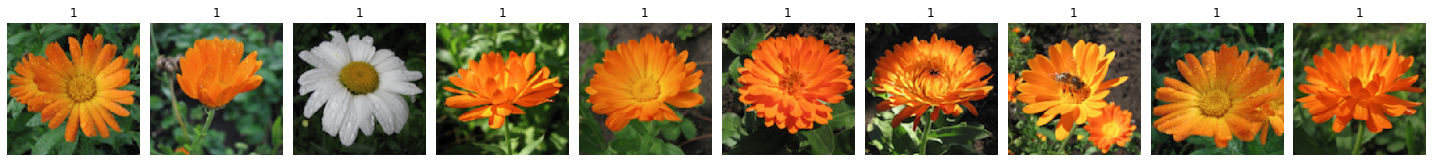

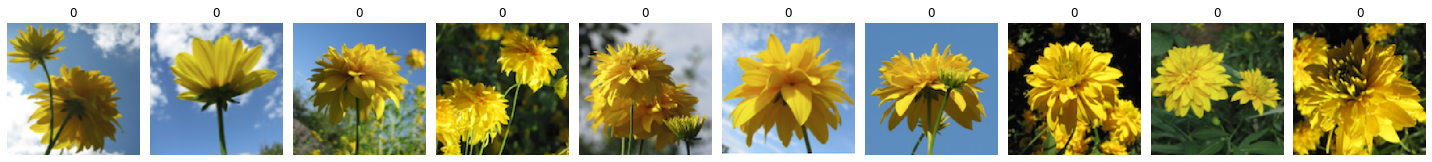

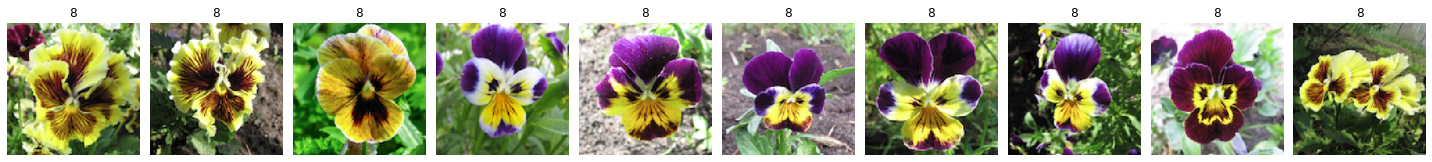

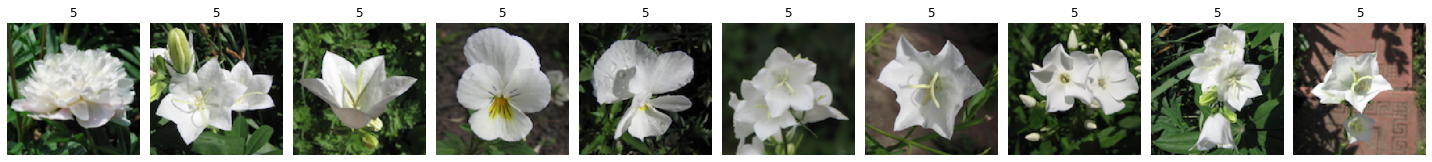

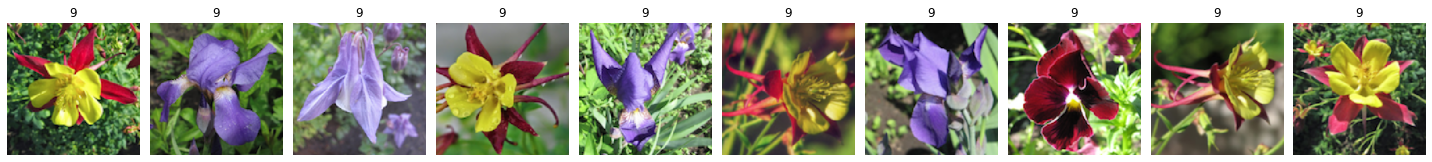

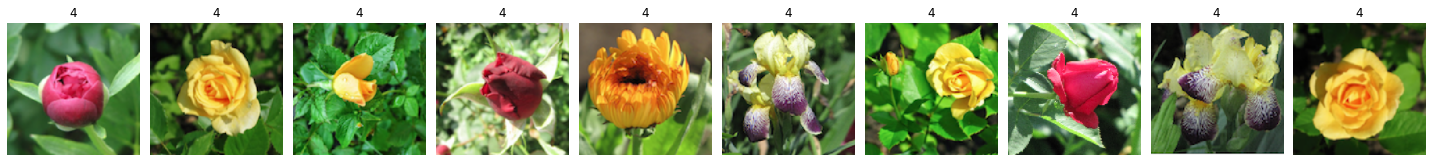

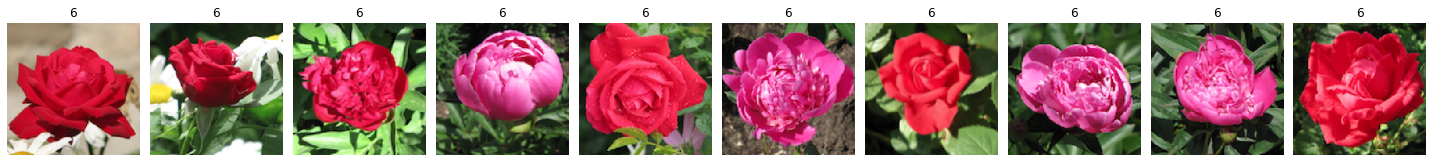

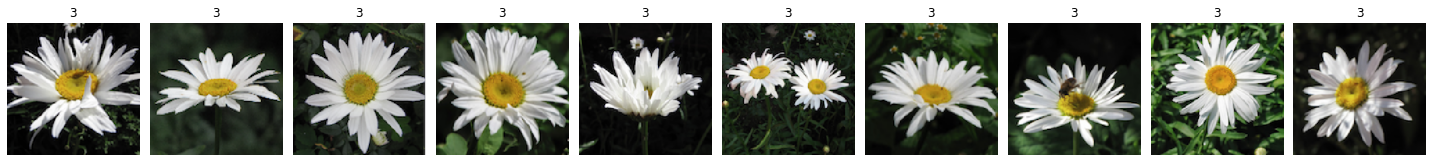

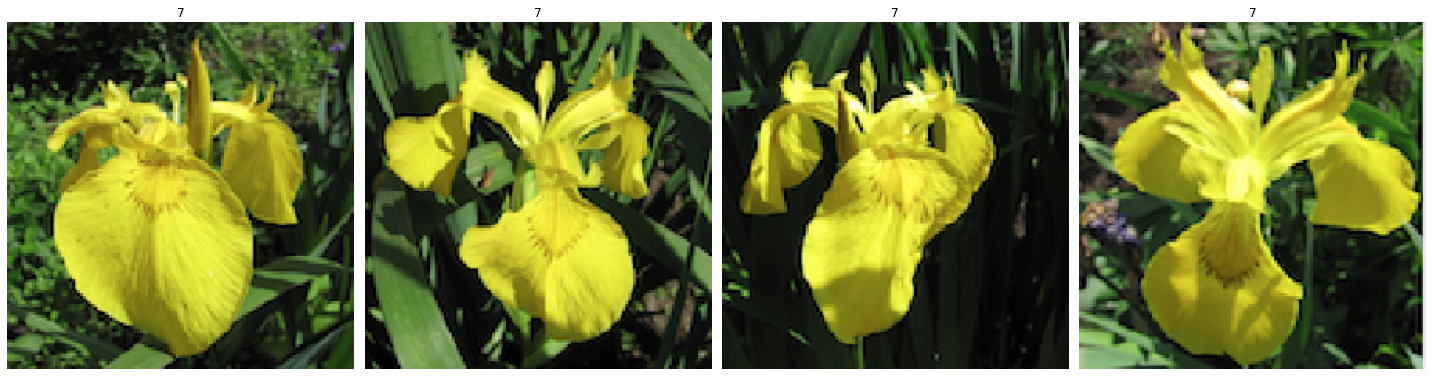

In [37]:
for cluster_set in groups.keys():
  show_images(root_folder, groups[cluster_set], cluster_set)

## Elbow test

In [41]:
def elbow_plot(features, clusters2test):
    clust = []
    final_distance = []
    l = features.shape[0]
    for cluster in range(2, clusters2test):
        clust = KMeans(n_clusters=cluster, random_state=22).fit_predict(features)
        distances_per_cl = []
        cluster_list = clust.tolist()
        weight = [cluster_list.count(cluster_num)/l for cluster_num in range(0, cluster)]
        for clu in range(cluster):
            centroide = features[np.where(clust == clu)[0],:].mean(axis = 0).reshape(1,-1)
            euc_distance = euclidean_distances(features[np.where(clust == clu)[0],:], centroide)
            distances_per_cl.append(euc_distance.mean())
            
        final_distance.append((np.array(distances_per_cl)@ weight)/len(distances_per_cl))
    
    plt.plot(list(range(2, clusters2test)),final_distance)
    
    return final_distance

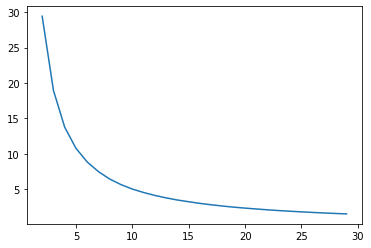

In [42]:
distances = elbow_plot(features, clusters2test=30)

In [46]:
diff = np.diff(distances)
diff

array([-10.46834348,  -5.20145538,  -2.98186128,  -1.94043619,
        -1.35588134,  -1.05009712,  -0.78473219,  -0.62395991,
        -0.4829235 ,  -0.41358538,  -0.34722046,  -0.30062162,
        -0.24355004,  -0.23525417,  -0.19409375,  -0.17834239,
        -0.15861432,  -0.13283959,  -0.12462719,  -0.11833494,
        -0.10522724,  -0.09509953,  -0.08512178,  -0.0828824 ,
        -0.07465425,  -0.07071179,  -0.06341192])

In [44]:
second_diff = np.diff(np.diff(distances))
second_diff

array([5.26688811e+00, 2.21959410e+00, 1.04142509e+00, 5.84554849e-01,
       3.05784227e-01, 2.65364925e-01, 1.60772285e-01, 1.41036404e-01,
       6.93381237e-02, 6.63649206e-02, 4.65988391e-02, 5.70715784e-02,
       8.29587001e-03, 4.11604210e-02, 1.57513591e-02, 1.97280641e-02,
       2.57747353e-02, 8.21240270e-03, 6.29224245e-03, 1.31077067e-02,
       1.01277074e-02, 9.97774535e-03, 2.23938474e-03, 8.22814794e-03,
       3.94246171e-03, 7.29987237e-03])

In [45]:
if second_diff[0] > 0:
    m_sign = 1
else:
    m_sign = 0
cluster_index = 0
for idx, elem in enumerate(second_diff):
    if (elem > 0 and m_sign == 0) or (elem < 0 and m_sign == 1):
        cluster_index = idx
        break
print('Suggested number of clusters: {}'.format(cluster_index))

Suggested number of clusters: 0
